In [ ]:
!pip install nltk==3.5
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.tokenize import RegexpTokenizer, WordPunctTokenizer
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import scipy.sparse as sparse
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

**Loading dataset**

In [ ]:
data_dir = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(data_dir, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.drop(['ids','flag','user'],axis=1,inplace=True)




**Check for missing data or null values in the data**


In [ ]:
np.sum(df.isnull().any(axis=1))


0

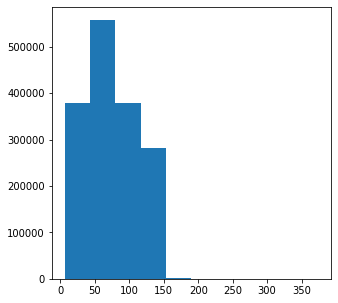

In [ ]:
df['length_of_tweets'] = [len(data) for data in df.text]
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(df['length_of_tweets'])
plt.show() 

**Histogram of target variables**


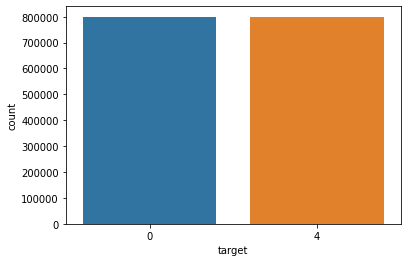

In [ ]:
sns.countplot(data=df, x='target')


**At what time of day do people tweet the most? Are tweets at a certain time more negative than others?**

<ipython-input-19-05625de8512a>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Date = df.date.str.replace('PDT', '')


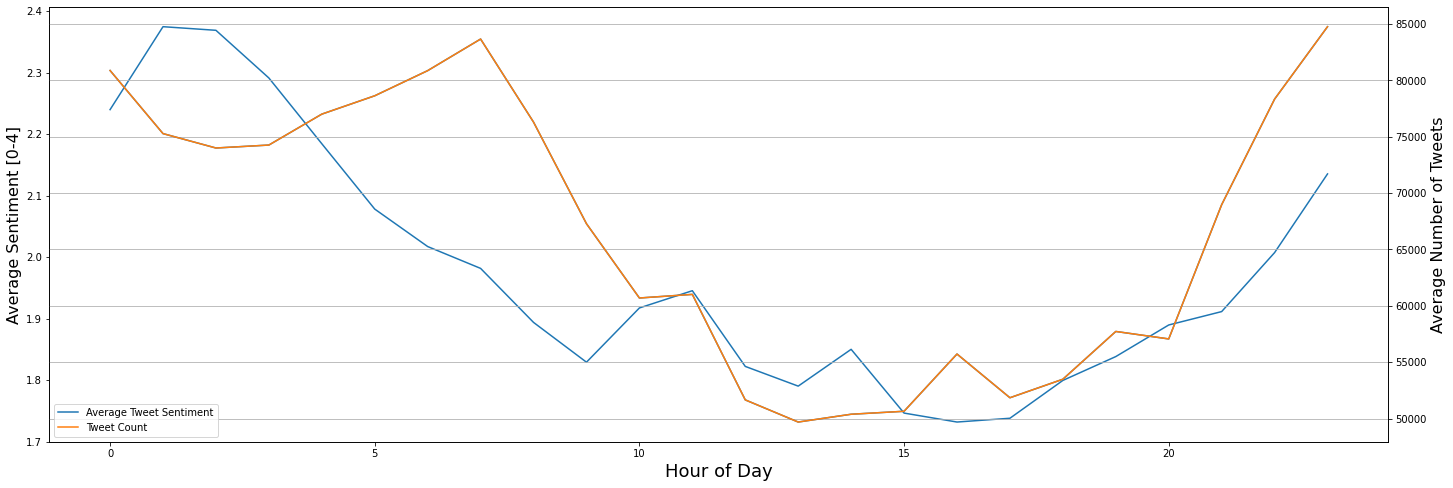

In [ ]:
df.Date = df.date.str.replace('PDT', '')
df.Date = pd.to_datetime(df.Date)
tweetie = df[['date','target']]
fig, ax = plt.subplots(1,1,figsize=(24,8))
obj = tweetie.groupby([df.Date.dt.hour])
ax.plot(obj.mean())
e = ax.twinx()
e.plot(obj.count())
e.grid(None)
plt.legend(['Average Tweet Sentiment', 'Tweet Count'], loc = 'lower left', fancybox = True)
ax.set_xlabel('Hour of Day', fontsize=18)
ax.set_ylabel('Average Sentiment [0-4]', fontsize=16)
e.set_ylabel('Average Number of Tweets', fontsize=16);

It seems like that people tweet more on average after the usual business hours at the end of the day and late into the night, although it seems like the most positive tweets occure at night and when people aren't working! People seem grumpier at work..

/usr/local/lib/python3.8/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


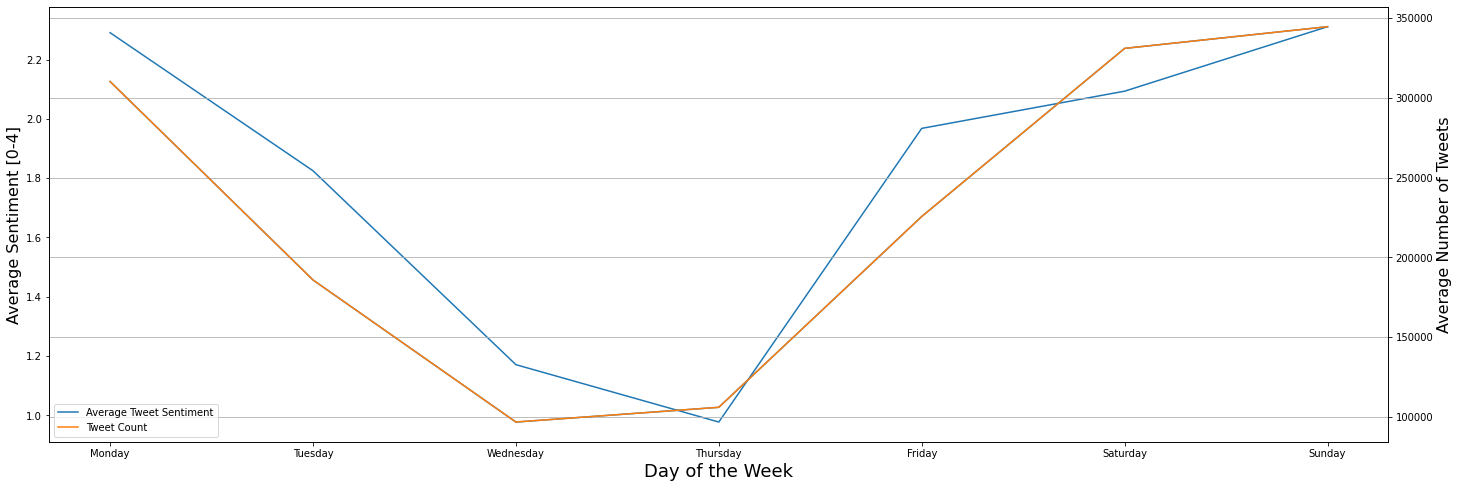

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
tweetie = df[['date','target']]
fig, ax = plt.subplots(1,1,figsize=(24,8))
obj = tweetie.groupby([df.date.dt.weekday])
ax.plot(obj.mean())
e = ax.twinx()
e.plot(obj.count())
e.grid(None)
plt.legend(['Average Tweet Sentiment', 'Tweet Count'], loc = 'lower left', fancybox = True)
fig.suptitle('', fontsize=20)
ax.set_xlabel('Day of the Week', fontsize=18)
ax.xaxis.set(ticks=range(0,7) ,ticklabels=['Monday' , 'Tuesday', "Wednesday", 'Thursday', "Friday", "Saturday", "Sunday"])
ax.set_ylabel('Average Sentiment [0-4]', fontsize=16)
e.set_ylabel('Average Number of Tweets', fontsize=16);

**Preprocess Data- remove stopwords, emojies, punctuations, repeating chars, URLs, stemming, lemmatization**

In [ ]:
# making statement text in lower case
df['text']=df['text'].str.lower()
df['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    is upset that he can't update his facebook by ...
2    @kenichan i dived many times for the ball. man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

In [ ]:
stopwordlist = set(['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves'])

# removing above words from the tweet statement
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
df['text'].head()


0    ['switchfoot', 'httptwitpiccomzl', 'awww', 'th...
1    ['upset', 'cant', 'update', 'facebook', 'texti...
2    ['kenichan', 'dived', 'many', 'times', 'ball',...
3    ['whole', 'body', 'feels', 'itchy', 'like', 'f...
4    ['nationwideclass', 'no', 'its', 'not', 'behav...
Name: text, dtype: object

In [ ]:
# remove punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].head()

0    switchfoot httptwitpiccom2y1zl  awww thats bum...
1    upset cant update facebook texting it might cr...
2    kenichan dived many times ball managed save 50...
3                     whole body feels itchy like fire
4    nationwideclass no its not behaving all im mad...
Name: text, dtype: object

In [ ]:
# remove repeating chars from each tweet statement
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'].head()


0    switchfoot httptwitpiccom21zl  awww thats bumm...
1    upset cant update facebook texting it might cr...
2    kenichan dived many times ball managed save 50...
3                     whole body feels itchy like fire
4    nationwideclass no its not behaving all im mad...
Name: text, dtype: object

In [ ]:
# remove URLs from tewwt statements
def cleaning_URLs(data):
    return re.sub('https?://[A-Za-z0-9./]+','',data)

    #return re.sub('((http?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].head()


0    switchfoot httptwitpiccom21zl  awww thats bumm...
1    upset cant update facebook texting it might cr...
2    kenichan dived many times ball managed save 50...
3                     whole body feels itchy like fire
4    nationwideclass no its not behaving all im mad...
Name: text, dtype: object

In [ ]:
# remove numeric values
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].head()

0    switchfoot httptwitpiccomzl  awww thats bummer...
1    upset cant update facebook texting it might cr...
2    kenichan dived many times ball managed save  r...
3                     whole body feels itchy like fire
4    nationwideclass no its not behaving all im mad...
Name: text, dtype: object

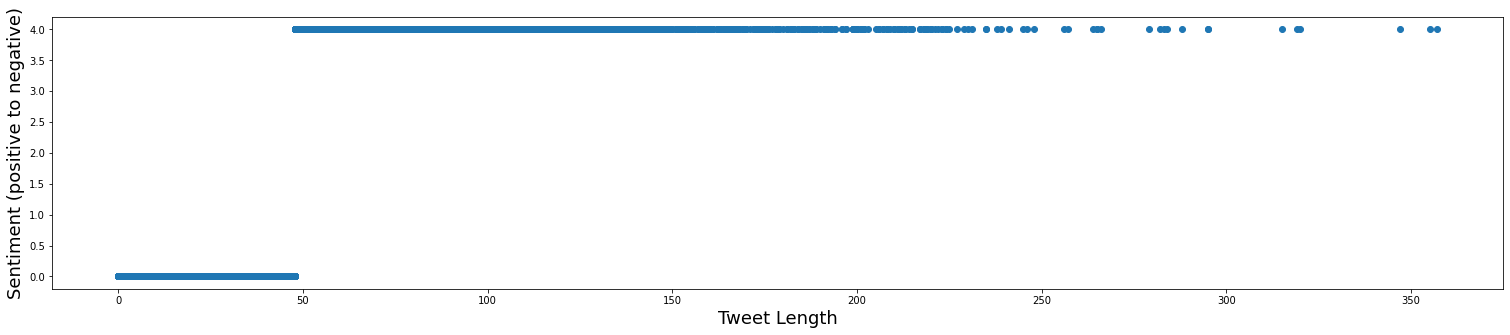

In [ ]:
df["length"] = df.text.str.len()
plt.figure(figsize=(26,5))
plt.scatter(df.sort_values('length')['length'],df.target)
plt.gca().set_xlabel('Tweet Length', fontsize=18)
plt.gca().set_ylabel('Sentiment (positive to negative)', fontsize=18);

With this visualization now enabled because any links, longer user mentions and HTML entities processed I would've expect the longer tweets to be more rant-like but surprisingly it's the other way around! Shorter tweets are always more negative than longer ones

Even more interesting is that this graph is shaped much like a logistic function, behind the scenes of making this notebook though, it actually worsened the logistic algorithm result!

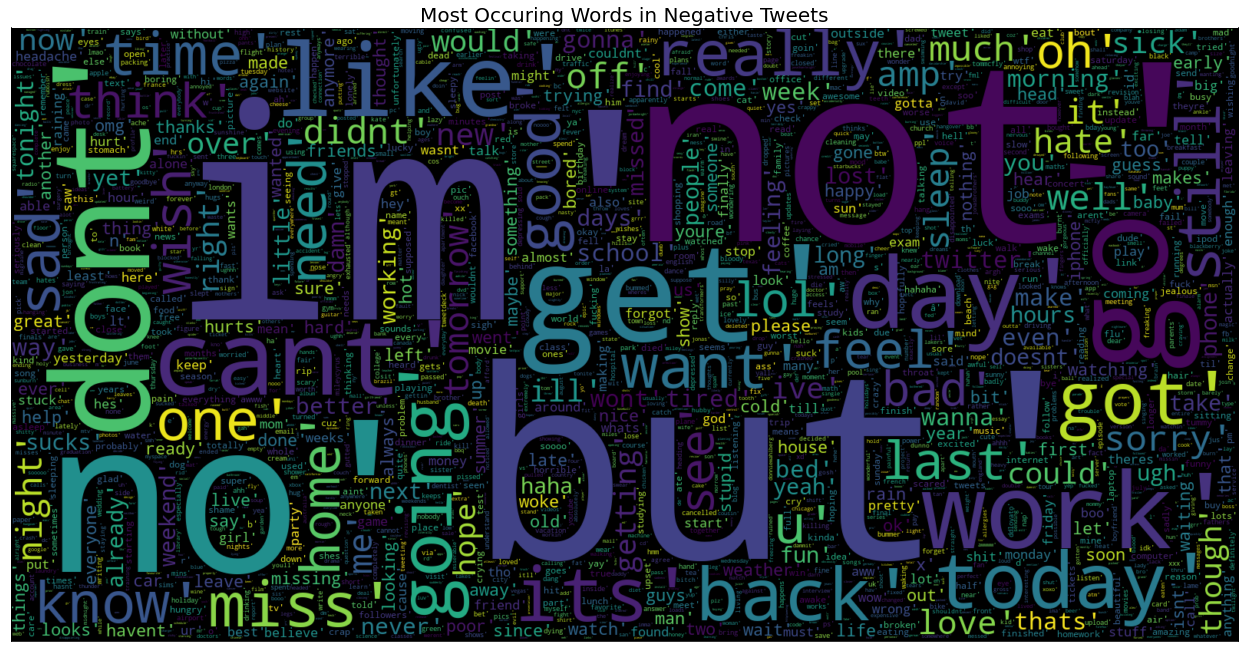

In [ ]:
#Normalizing target to be from 0 to 1 as it's easier to deal with for the algorithms
df.target = df.target.apply(lambda x : 0 if x ==0 else 1)
plt.figure(figsize = (22,22)) 
ax = plt.gca()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
stopwordlist.update({'url','user'})
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,collocations=False,stopwords= stopwordlist).generate(" ".join(df[df.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear');
ax.set_title('Most Occuring Words in Negative Tweets', fontsize=20);

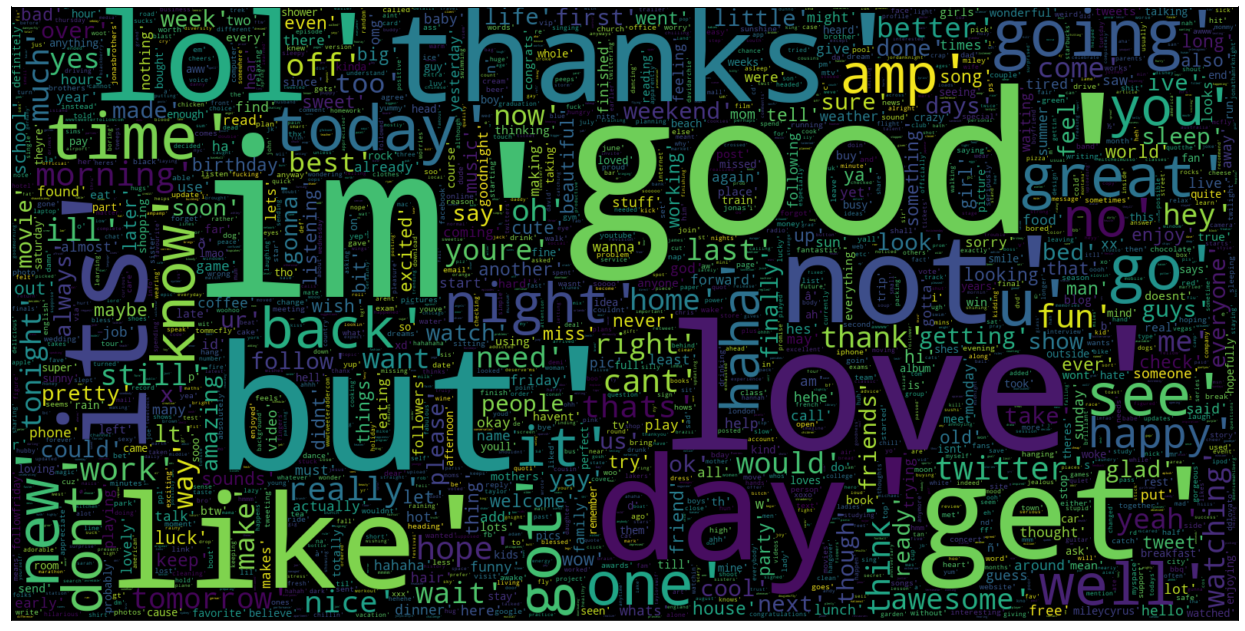

In [ ]:
plt.figure(figsize = (22,22)) 
ax = plt.gca()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
stopwordlist.update({'url','user'})
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,collocations=False,stopwords= stopwordlist).generate(" ".join(df[df.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear');

In [ ]:
# tokenization of tweet text
tokenizer = RegexpTokenizer("[\w']+")
df['text'] = df['text'].apply(tokenizer.tokenize)
df['text'].head()

0    ['switchfoot', 'httptwitpiccomzl', 'awww', 'th...
1    ['upset', 'cant', 'update', 'facebook', 'texti...
2    ['kenichan', 'dived', 'many', 'times', 'ball',...
3    ['whole', 'body', 'feels', 'itchy', 'like', 'f...
4    ['nationwideclass', 'no', 'its', 'not', 'behav...
Name: text, dtype: object

In [ ]:
df_text = list(df['text'])
joined_text = []
for lst in df_text:
  joined_text.append(" ".join(lst))

clean_df = pd.DataFrame(joined_text, columns=['text'])
clean_df.head

<bound method NDFrame.head of                                                       text
0        'switchfoot' 'httptwitpiccomzl' 'awww' 'thats'...
1        'upset' 'cant' 'update' 'facebook' 'texting' '...
2        'kenichan' 'dived' 'many' 'times' 'ball' 'mana...
3             'whole' 'body' 'feels' 'itchy' 'like' 'fire'
4        'nationwideclass' 'no' 'its' 'not' 'behaving' ...
...                                                    ...
1599995  'woke' 'up' 'no' 'school' 'best' 'feeling' 'ever'
1599996  'thewdbcom' 'cool' 'hear' 'old' 'walt' 'interv...
1599997          'ready' 'mojo' 'makeover' 'ask' 'details'
1599998  'happy' 'th' 'birthday' 'boo' 'alll' 'time' 't...
1599999  'happy' 'charitytuesday' 'thenspcc' 'sparkscha...

[1600000 rows x 1 columns]>

In [ ]:
clean_df['target'] = df['target']
clean_df.to_csv('/content/drive/MyDrive/sentinemt150_clean.csv', encoding='utf-8')


In [ ]:
clean_df = pd.read_csv("/content/drive/MyDrive/sentinemt150_clean.csv")
clean_df.head()


,Unnamed: 0,text,target
0,0,'switchfoot' 'httptwitpiccomzl' 'awww' 'thats'...,0
1,1,'upset' 'cant' 'update' 'facebook' 'texting' '...,0
2,2,'kenichan' 'dived' 'many' 'times' 'ball' 'mana...,0
3,3,'whole' 'body' 'feels' 'itchy' 'like' 'fire',0
4,4,'nationwideclass' 'no' 'its' 'not' 'behaving' ...,0


**Splitting data into train and test sets**

In [ ]:
X=clean_df.text
y=clean_df.target

**Split dataset into train and test**

In [ ]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =26105111)

In [ ]:
X_train

477257                                            rachele no
555718     grizzlovesyou yuppp busy collecting stones los...
964030     dazzlem thats great idea hmmm anoop cupcakes l...
1023468    mateoamarei hmph even though still punishment ...
160610                    cannot sleep hours tossing turning
                                 ...                        
724937                     nigga wanna go homeaint home days
1201868                                 watching hockey game
521390     anyone contacts people uni nevada las vegas iv...
974580                          amazing night amazing person
18431      hope cal day amp picnic day davis not schedule...
Name: text, Length: 1280000, dtype: object

**Transforming Dataset using TF-IDF Vectorizer**

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train.values.astype('U'))
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [ ]:
X_train = vectoriser.transform(X_train.values.astype('U'))
X_test  = vectoriser.transform(X_test.values.astype('U'))

In [ ]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
prediction = dict()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)
prediction['Multinomial'] = model.predict(X_test)


In [ ]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
prediction['SVC'] = SVCmodel.predict(X_test)

In [ ]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(solver='liblinear', C = 2, max_iter = 1000)
logreg.fit(X_train, y_train)
prediction['Logistic'] = logreg.predict(X_test)

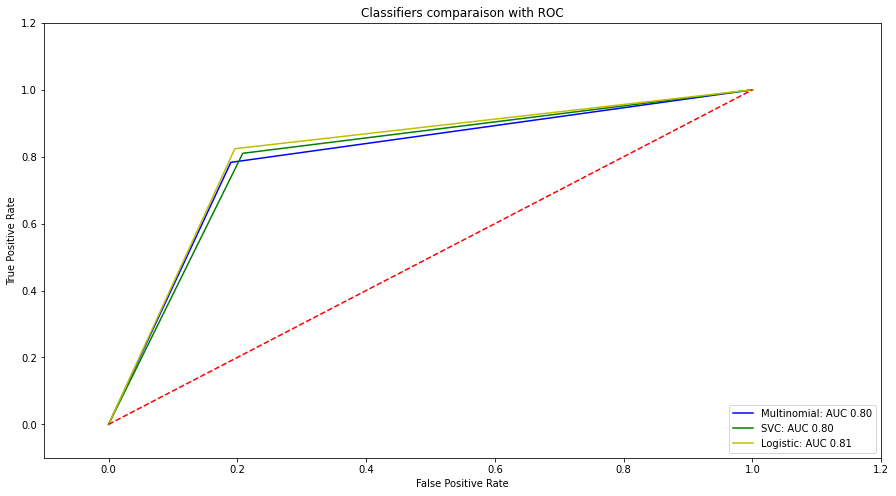

In [ ]:
#Plotting an AUC-ROC curve to compare algorithms
cmp = 0
colors = ['b', 'g', 'y','cyan']
plt.figure(figsize=(15,8))
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1
plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.82      0.80      0.81    159838
    negative       0.81      0.82      0.82    160162

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



The AUC-ROC curve above indicates that Logistic Regression gave us the best possible performance of the three.

